# This is Step 1 in the Pipeline - Verifying the Quality of Spec2Vec Embeddings
With this notebook we test the similarity of the Spec2Vec embeddings by testing the retrieval of similar spectra.
In Ideas scenario top N (where N is the amount of spectra for the inchi_key) similar spectra should belong to the same inchi_key.

### Imports

In [5]:
import pandas as pd
import gensim
from spec2vec import Spec2Vec
from matchms import calculate_scores
from mass_spectra.train_spec2vec import preprocess_file
from rdkit import Chem
from math import ceil

### Data Source

In [6]:
MODEL = "./source/spec2vec/all_positive/spec2vec.model"
SPECTRA = "./source/dataset/Test dataset_TMS_RAW.mgf"
INCHIKEY_TO_INCHI_FILE = "./source/embedding/all_positive_all_fingerprints/fingerprint.csv"

### Read and Organize Data

In [7]:
model = gensim.models.Word2Vec.load(MODEL)
model = Spec2Vec(model=model,
                               intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

In [8]:
spectra = preprocess_file(SPECTRA)

In [9]:
spectra[0].metadata

{'mass': '194.076',
 'charge': 1,
 'title': 'InChiKey:  VFFKJOXNCSJSAQ-UHFFFAOYSA-N, Name: Benzoic acid, trimethylsilyl ester',
 'inchikey': 'VFFKJOXNCSJSAQ-UHFFFAOYSA-N',
 'compound_name': 'Benzoic acid, trimethylsilyl ester',
 'ionmode': 'n/a',
 'inchi': '',
 'smiles': ''}

In [10]:
# Make sure the spectra are sorted by inchikey
spectra = sorted(spectra, key=lambda x: x.metadata['inchikey'])

In [11]:
count_by_inchikey = {}
for s in spectra:
    key = s.metadata['inchikey']
    count_by_inchikey[key] = count_by_inchikey.get(key, 0) + 1

In [12]:
inchikey_to_inchi = pd.read_csv(INCHIKEY_TO_INCHI_FILE)
inchikey_to_inchi = inchikey_to_inchi[["inchi_key", "inchi"]]

In [13]:
def inchi_from_inchikey(inchi):
    values = inchikey_to_inchi[inchikey_to_inchi["inchi_key"] == inchi]
    if len(values) == 0:
        return None
    return values.iloc[0]["inchi"]

### Heatmap of Spec2Vec Similarity

In [14]:
scores = calculate_scores(spectra, spectra, model, is_symmetric=True)

In [15]:
scores_array = scores.scores.to_array()

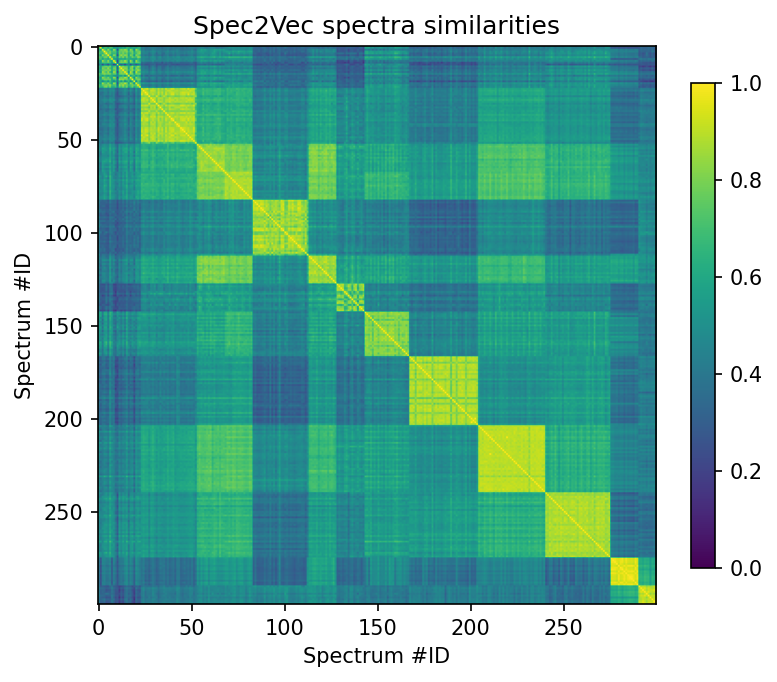

In [16]:
N_s = 200
N_e = 500

from matplotlib import pyplot as plt
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array[N_s:N_e, N_s:N_e], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Spec2Vec spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.clim(0, 1) # Spec2Vec scores can be between -1 and 1

### Visual comparison of the Results in the same Inchi Key

In [17]:
ID = 2000
inchi_key = spectra[ID].metadata['inchikey']
N = count_by_inchikey[inchi_key]
best_matches = scores.scores_by_query(spectra[ID], sort=True)[:N]

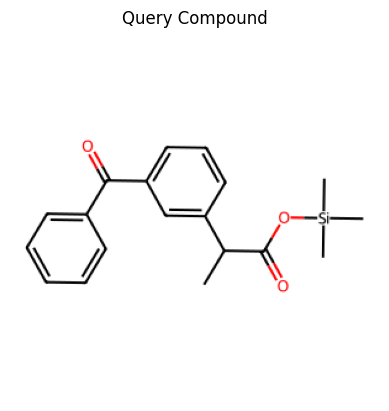

In [18]:
query_inchi = inchi_from_inchikey(inchi_key)
img = Chem.Draw.MolToImage(Chem.MolFromInchi(query_inchi), size=(300, 300))
plt.imshow(img)
plt.title("Query Compound")
plt.gca().set_axis_off()

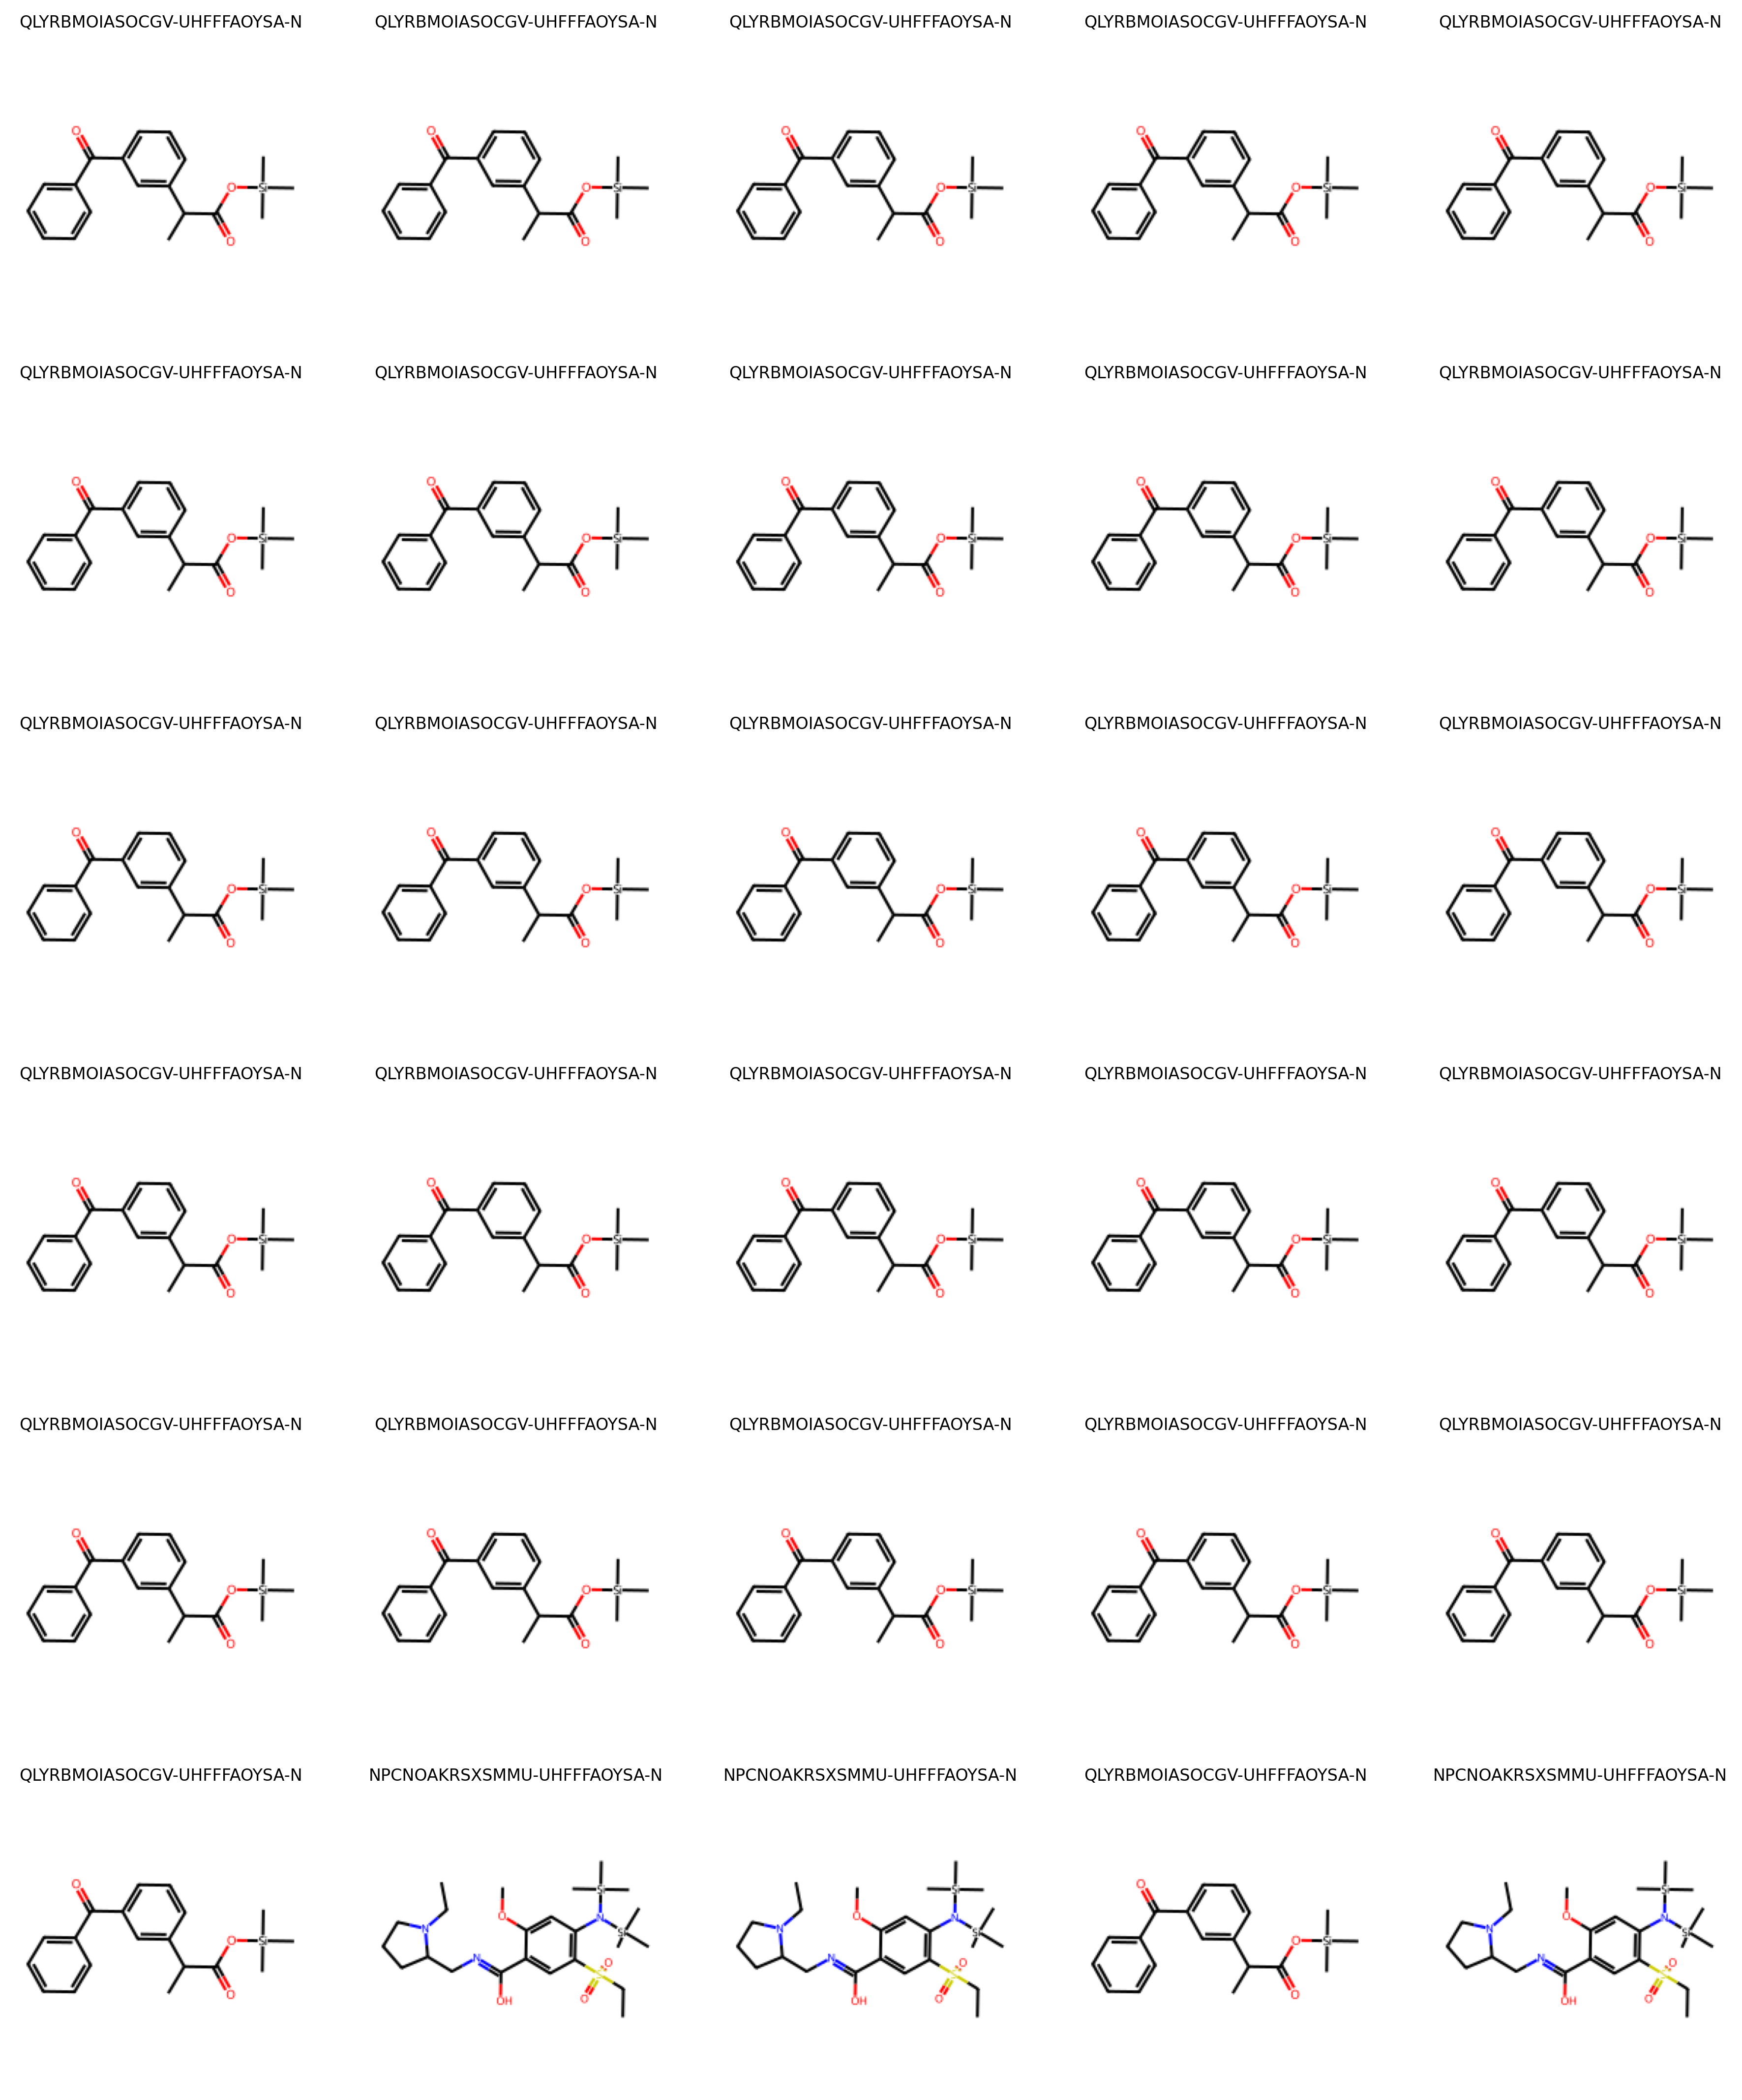

In [19]:
size = len(best_matches)
fig, axes = plt.subplots(ceil(size/5), 5, figsize=(15, 3*ceil(size/5)), dpi=300)

last_used = 0
for i, inchikey in enumerate([x[0].get("inchikey") for x in best_matches]):
    ax = axes[i//5, i%5]

    inchi = inchi_from_inchikey(inchikey)
    if inchi is None:
        ax.set_title(f"{inchikey} (not found)", fontdict={"fontsize": 8})
        ax.set_axis_off()
        continue
    m = Chem.inchi.MolFromInchi(inchi)

    ax.set_title(f"{inchikey}", fontdict={"fontsize": 8})
    ax.set_axis_off()
    ax.set_aspect('equal')

    pil_img = Chem.Draw.MolToImage(m, size=(200, 200))
    ax.imshow(pil_img)
    last_used = i

for i in range(last_used+1, axes.size):
    ax = axes[i//5, i%5]
    ax.set_axis_off()
plt.show()

### Visual comparison of the Results outside of the same Inchi Key

In [20]:
ID = 1000
inchi_key = spectra[ID].metadata['inchikey']
N = count_by_inchikey[inchi_key]
best_matches = scores.scores_by_query(spectra[ID], sort=True)[N:N+30]

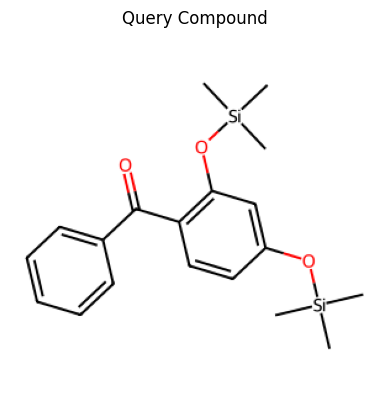

In [21]:
query_inchi = inchi_from_inchikey(inchi_key)
img = Chem.Draw.MolToImage(Chem.MolFromInchi(query_inchi), size=(300, 300))
plt.imshow(img)
plt.title("Query Compound")
plt.gca().set_axis_off()

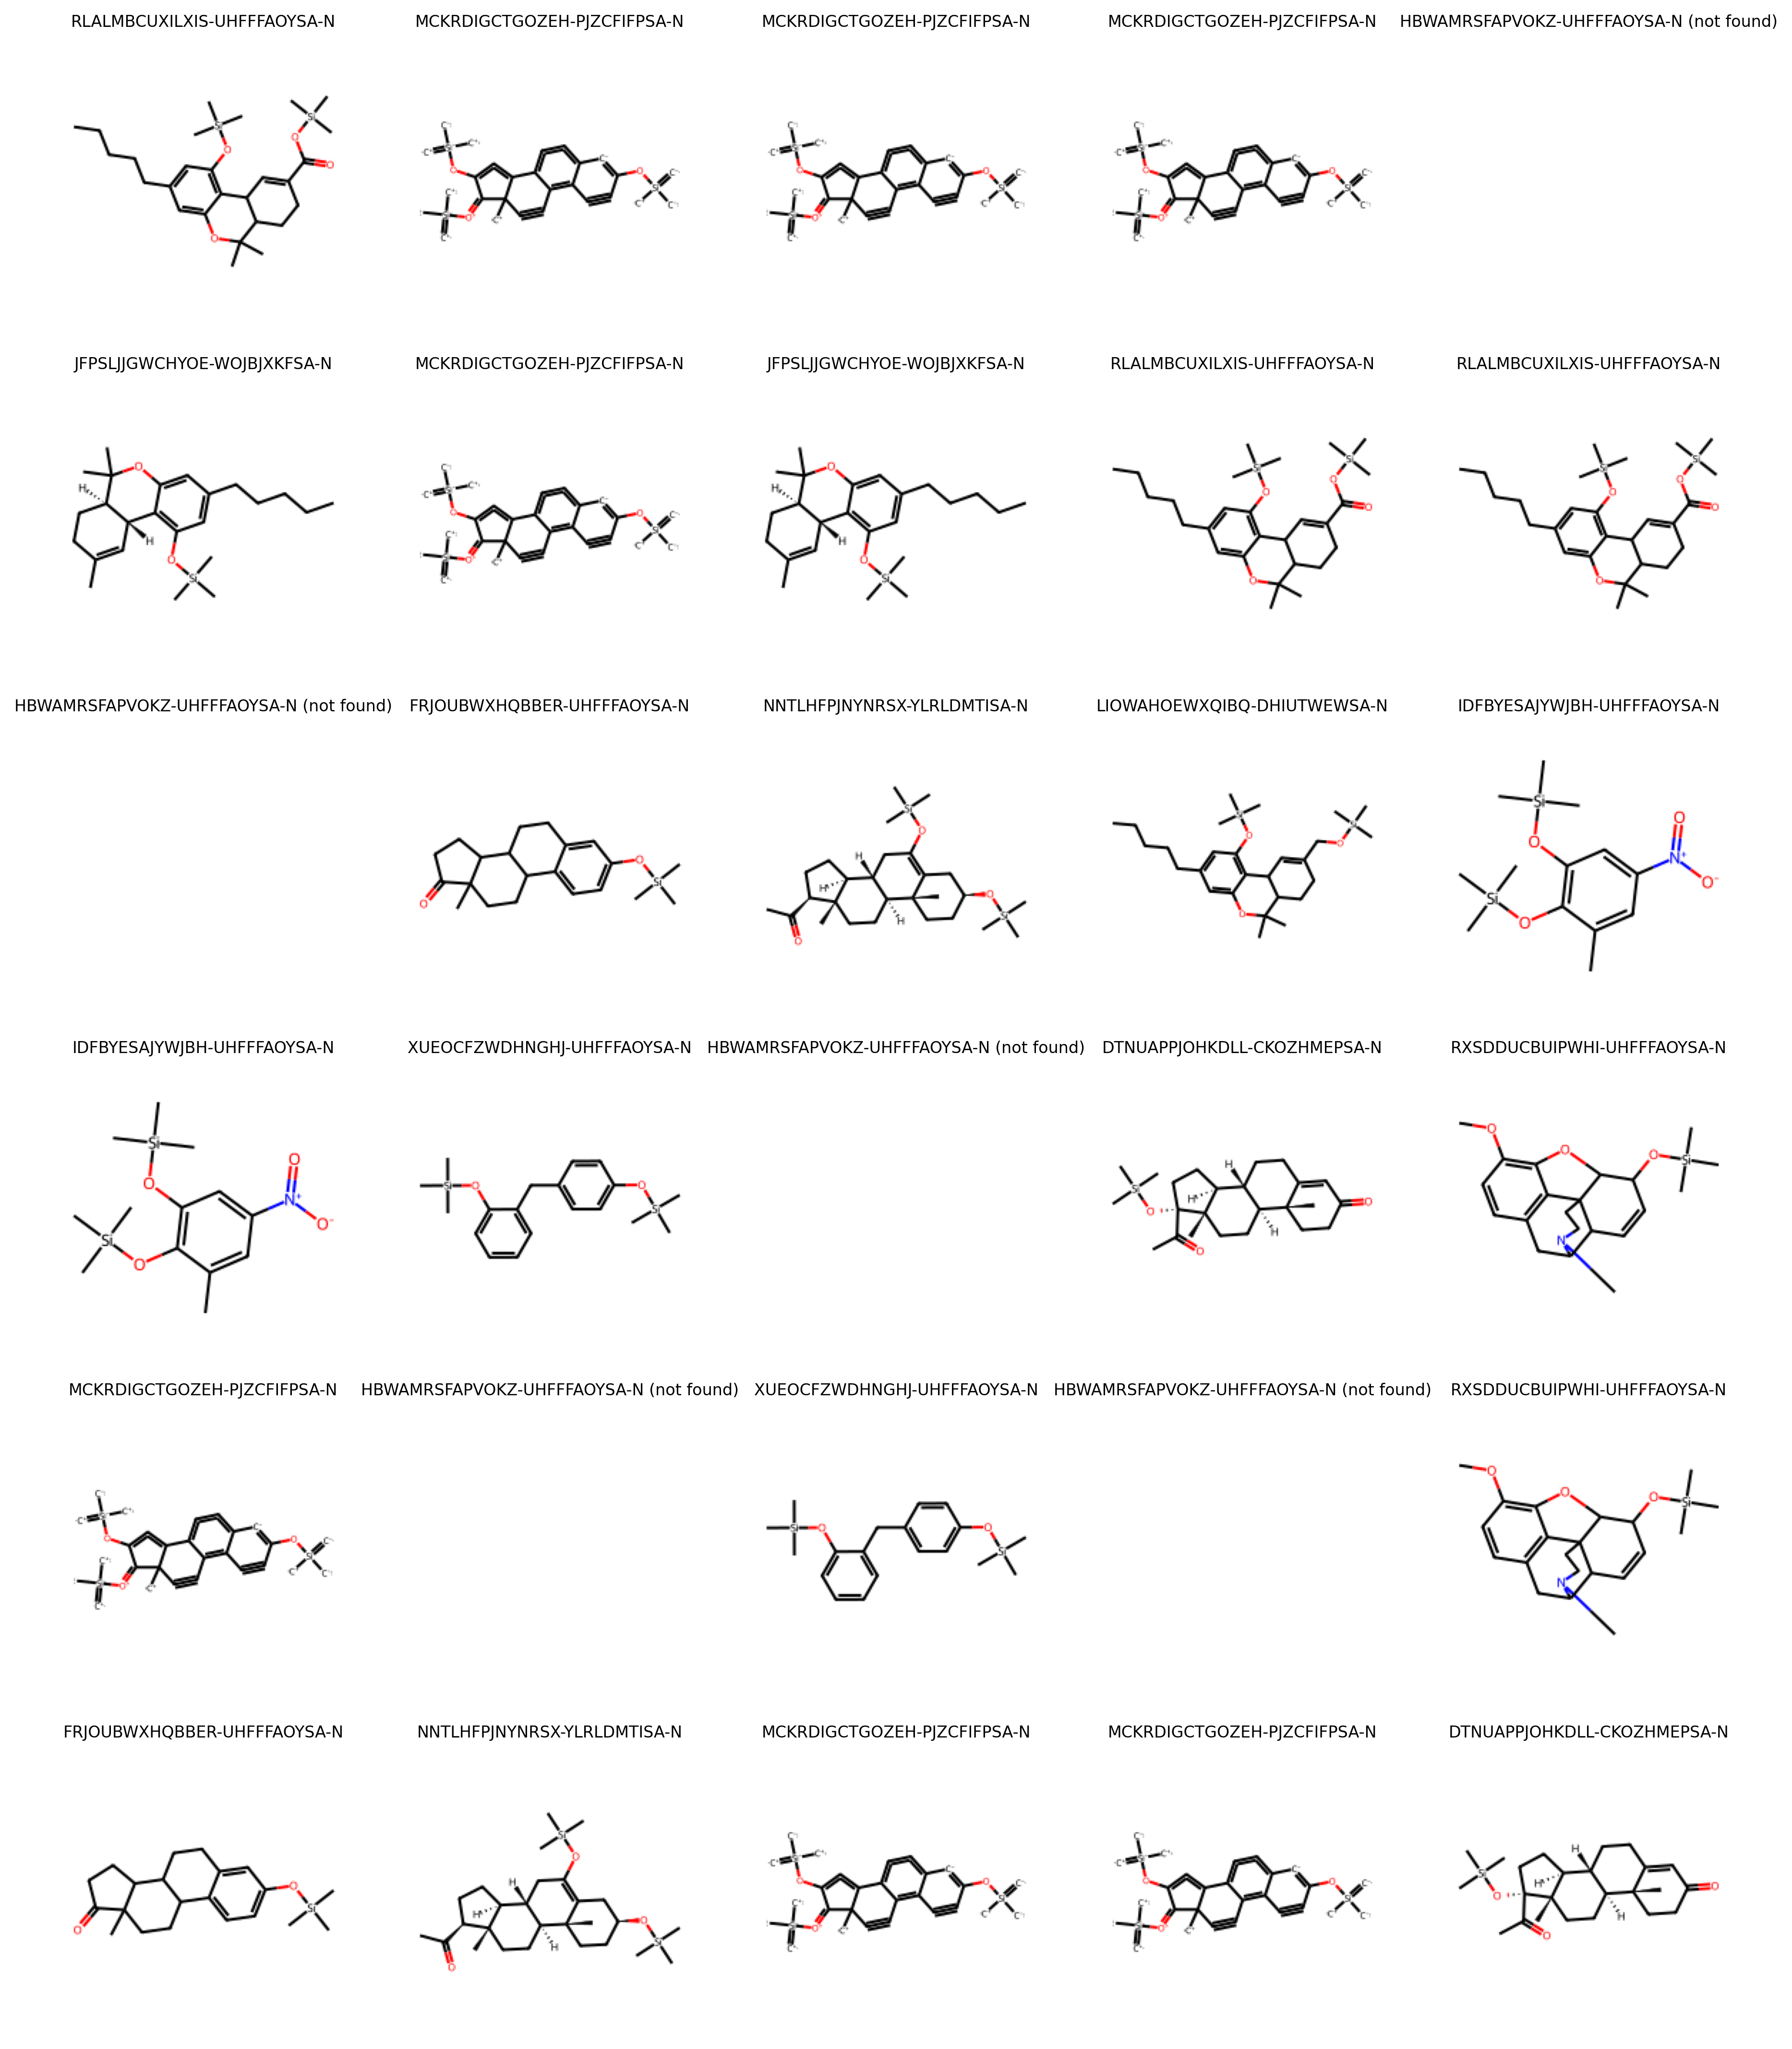

In [22]:
size = len(best_matches)
fig, axes = plt.subplots(ceil(size/5), 5, figsize=(15, 3*ceil(size/5)), dpi=300)

last_used = 0
for i, inchikey in enumerate([x[0].get("inchikey") for x in best_matches]):
    ax = axes[i//5, i%5]

    inchi = inchi_from_inchikey(inchikey)
    if inchi is None:
        ax.set_title(f"{inchikey} (not found)", fontdict={"fontsize": 8})
        ax.set_axis_off()
        continue
    m = Chem.inchi.MolFromInchi(inchi)


    ax.set_title(f"{inchikey}", fontdict={"fontsize": 8})
    ax.set_axis_off()
    ax.set_aspect('equal')

    pil_img = Chem.Draw.MolToImage(m, size=(200, 200))
    ax.imshow(pil_img)
    last_used = i

for i in range(last_used+1, axes.size):
    ax = axes[i//5, i%5]
    ax.set_axis_off()
plt.show()